In [12]:
import os, sys, shutil, string, re
import numpy as np
import ROOT
# from ROOT import (TFile,TTree,TH1D,TCanvas,TGraphErrors,
#                   TSelector,TF1,kTRUE,gPad,gStyle,gROOT,
#                   gDirectory,RooFit,RooRealVar,RooVoigtian,
#                   RooExponential,RooAddPdf,RooFitResult,
#                   RooMsgService,RooDataSet,RooDataHist,
#                   RooWorkspace,RooArgSet)

import matplotlib.pyplot as plt
from subprocess import call
from array import array

RooMsgService.instance().setStreamStatus(1,False);

# sys.path.append('/home/rosedj1/HiggsMeasurement/')
# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_8_0_32/src/PyUtils/')

In [19]:
data_rooabsdata = ROOT.RooAbsData(data)

TypeError: none of the 3 overloaded methods succeeded. Full details:
  RooAbsData is abstract and can not be instantiated
  RooAbsData is abstract and can not be instantiated
  RooAbsData is abstract and can not be instantiated

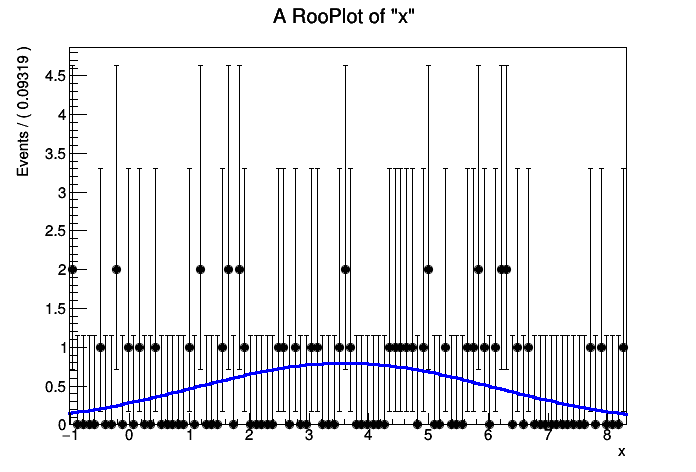

In [62]:
data = np.random.normal(loc=3.5, scale=2, size=50)

tree = ROOT.TTree("tree","tree")
x = np.zeros(1,dtype=float)
tree.Branch("x",x,'x/D')

for i in range(len(data)):
    x[0] = data[i]
    tree.Fill()

c = ROOT.TCanvas()
c.Draw()

x_min = data.min() * 1.01
x_max = data.max() * 1.01
x_avg = data.mean()
x_std = data.std()

x = ROOT.RooRealVar("x","x", x_min, x_max)
mean = ROOT.RooRealVar("mean","Mean of Gaussian", x_avg, x_min, x_max)
sigma = ROOT.RooRealVar("sigma","Width of Gaussian", x_std, x_min, x_max)
gauss = ROOT.RooGaussian("gauss","gauss(x,mean,sigma)", x, mean, sigma)

# data = gauss.generate(ROOT.RooArgSet(x),10000)
data_fromtree = ROOT.RooDataSet("data", "test_data_from_treefilledfromarray", tree, ROOT.RooArgSet(x))

xframe = x.frame()
data_fromtree.plotOn(xframe, ROOT.RooLinkedList())
gauss.plotOn(xframe)
xframe.Draw()

result = gauss.fitTo(data_fromtree, ROOT.RooFit.PrintLevel(-1))

# Fit over a range.
# gauss.fitTo(data, ROOT.RooFit.Range(-5,5), ROOT.RooFit.PrintLevel(-1))

In [63]:
best_fit_mu = mean.getVal()
best_fit_mu_err = mean.getError()
best_fit_std = sigma.getVal()
best_fit_std_err = sigma.getError()
mean.Print()
sigma.Print()
# sigma.setRange(0.1,3)

RooRealVar::mean = 3.46812 +/- 1.1011  L(-1.0083 - 8.3107) 
RooRealVar::sigma = 4.40819 +/- 1.91472  L(-1.0083 - 8.3107) 


In [64]:
print(best_fit_mu, best_fit_mu_err)
print(best_fit_std, best_fit_std_err)

(3.468122996791506, 1.101096390360319)
(4.408192973221528, 1.9147192794244117)


In [66]:
print(data.mean())
print(data.std())

3.595382307035791
2.4955426610016573


### Make array of test data and do unbinned Gaussian fit:

In [2]:
class MllHistFit:
    def __init__(self,
                 fs,
                 d0_range,
                 inpath_file,
                 outpath,
                 massZ_lo,
                 massZ_hi,
                 bin_width,
                 n_bins_ZErr,
                 cuts="",
                 overwrite=False
                 ): 
        """
        
        Create a histogram to be manipulated using user-defined methods.
        
        Parameters:
        -----------
        fs : str
            Final state.
        d0_range : array_like
            [initial_d0, final_d0]
        inpath_file : str
            Input file path.
        outpath : str
            Output file path.
        massZ_lo : float
            Lower-bound of mll plot.
        massZ_hi : float
            Upper-bound of mll plot.
        bin_width : float
            Bin width for all bins.
        n_bins_ZErr : int
            Number of bins to use in ZErr analysis.
        cuts : string, optional
            Cuts to apply to each event. Default = "".
        overwrite : bool
            If false (default) will NOT overwrite MySelector(.C,.h) found in inpath_file
        
        Returns
        -------
        Nothing yet.
        """
        self.fs = fs
        self.cuts = cuts
        self.d0_range = d0_range
        self.filename = filename
        self.outpath = outpath
        self.massZ_lo = massZ_lo
        self.massZ_hi = massZ_hi
        self.bin_width = bin_width
        self.n_bins_ZErr = n_bins_ZErr 
        
        #----- Automatic stuff -----#
        self.n_bins = int(round( (massZ_hi-massZ_lo)/bin_width ))
        d0_min = str(d0_range[0])
        d0_max = str(d0_range[1])
        if cuts not in "": 
            cuts = cuts + " &&"
        self.cuts += "%s < d0BS1 && " % d0_min
        self.cuts += "%s < d0BS2 && " % d0_min
        self.cuts += "%s > d0BS1 && " % d0_max
        self.cuts += "%s > d0BS2"     % d0_max
        
        # Access file and tree info.
        self.file = TFile(filename)
        self.tree = self.file.Get("passedEvents")
        print 'tree opened'
        
        # Make dataset objects and a histogram object to store data.
        self.Data_Zlls = RooDataSet()
        self.Data_Zlls_w = RooDataSet()
        self.Data_Zlls_binned = RooDataHist()
        
        # Cut to make dataset
#         self.cuts = " (massZ > "+str(self.massZ_lo)+" && massZ < "+str(self.massZ_hi)+") && "
#         self.cuts += " (massZErr > "+str(self.massZErr_lo)+" && massZErr < "+str(self.massZErr_hi)+") && "

        self.w = RooWorkspace("w","workspace")
            
        # Holds the input and output of a PDF fit to a dataset.
        w = RooWorkspace("w","workspace")
        self.fit_result = RooFitResult() 
    #---------------------------------------------------------------------#
    def prepare_dataset(self):
        # I'm a little confused... I thought that RooRealVar massZ was defined here,
        # but instead Hualin defines it in the next method, "combine_pdfs"...
        # Maybe it doesn't matter.
        
        self.tree.Draw(">>myList", self.cuts, "entrylist")
        # I think SetEntryList has something to do with PROOF and parallel processing.
        entryList = gDirectory.Get("myList")
        self.tree.SetEntryList(entryList)
        
         # Make selector object.
        cwd = os.environ['PWD']
        selector_name = "MySelector"
        fullpath_selector = os.path.join(cwd,selector_name+".C")
        if not os.path.exists(fullpath_selector) and (overwrite):
            print "Making new selector file:", 
            self.tree.MakeSelector(selector_name)
        selector = TSelector.GetSelector(fullpath_selector)
        
        # These methods are defined in MySelector.C.
        selector.SetNumBins(self.n_bins)
        selector.SetNumBins_ZErr(self.n_bins_ZErr)
        selector.SetRange_massZ(self.massZ_lo, self.massZ_hi)
        selector.SetRange_massZErr(0, 9999)
#         selector.SetLambda( int(self.doLambda1), self.Lambdas["lambda1"], self.Lambdas["lambda2"] )

#       These variables are from MySelector.h. Putting them here for easy reference. 
#         rv_weight   = new RooRealVar("weight","weight", 0.00001, 100);
#         rv_massZ    = new RooRealVar("massZ","massZ", massZ_lo, massZ_hi);
#         rv_massZErr = new RooRealVar("massZErr","massZErr", massZErr_lo, massZErr_hi);
#         rastmp      = new RooArgSet(*rv_massZ, *rv_massZErr, *rv_weight);
#         Data_Zlls   = new RooDataSet("Zlls","Zlls", *rastmp);
#         massZ = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
#         massZErr = RooRealVar("massZErr","massZErr", self.massZErr_lo, self.massZErr_hi)

#         for key,val in self.shapePara.items():
#             print key,":",val

        # This is the big boy: run the Process method.
        # Go event by event in the tree and grab everything defined in 
        # the Process() section of MySelector.C.
        self.tree.Process(selector)
        
        self.Data_Zlls = selector.Data_Zlls # Store the values in a RooDataSet called Data_Zlls
        # Use Data_Zlls dataset to make a new dataset of WEIGHTS? 
        self.Data_Zlls_w = RooDataSet(self.Data_Zlls.GetName(), self.Data_Zlls.GetTitle(), self.Data_Zlls, self.Data_Zlls.get(), "1", "weight")
        print "RooDataSet after cuts has " + str(self.Data_Zlls.numEntries()) + " events."
        print "Cuts applied:\n", self.cuts
#         self.Data_Zlls_binned = self.Data_Zlls_w.binnedClone()
        
        return self.w, self.Data_Zlls_w
        
        
        #---------------------------------------------------------------------#
    def combine_pdfs(self):
        """
        Creates the different PDFs (Voigtian signal, Exp bkg) and combines them into a "model".
        """
        massZ    = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
        massZErr = RooRealVar("massZErr","massZErr", -999,999)
        gaus_mean = RooRealVar("gaus_mean","#mu_{gaus}",-999,999)
        gaus_sigma = RooRealVar("gaus_sigma","#sigma_{gaus}",0,999)
        bw_mean = RooRealVar("bw_mean","#mu_{BW}",0,999)
        bw_width = RooRealVar("bw_width","#Gamma_{BW}",0,999)
#         BW = RooBreitWigner("BW","Breit Wigner theory", massZ, breitWignerMean,breitWignerGamma)
#         breitWignerMean   = RooRealVar("breitWignerMean", "m_{Z^{0}}", self.GENZ_mean)
#         breitWignerGamma  = RooRealVar("breitWignerGamma", "#Gamma", self.GENZ_width)
#         breitWignerGamma.setConstant(kTRUE)
#         breitWignerMean.setConstant(kTRUE)        tau = RooRealVar("tau","#tau",-999,999)
        tau = RooRealVar("tau","#tau",-10,10)
        coeff = RooRealVar("coeff","coeff",-999,999)

        # voigtian = BWxGaussian: const char* name, const char* title, RooAbsReal& _x, RooAbsReal& _mean, RooAbsReal& _width, RooAbsReal& _sigma, Bool_t doFast = kFALSE
        voigt = RooVoigtian("voigt","voigt",massZ,gaus_mean,bw_width,gaus_sigma)  # I believe this does the convolution on its own.
        exp = RooExponential("exp","exp_bkg",massZ,tau)
        
        #pa2 = RooRealVar("pa2","pa2", 0.0098, -10,10)
        #p2 = RooFormulaVar("p2", "@1*@0+@2*@0*@0",RooArgList(massZ,pa1,pa2)) # may not be used
        
        model = RooAddPdf("model","sig_plus_bkg_model", voigt, exp, coeff)
        getattr(self.w,'import')(model) # same as doing: self.w.import(model)
        
#------------------------------------------------------------------------------#      
    def do_fit(self):
        print "Number of entries in workspace Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
        if self.Data_Zlls_w.numEntries() < 5000:
            print "Using an UN-binned fit."
#             mZ = self.w.var("massZ")
#             pdf_sum = self.pdf("model")
#             frame = mZ.frame()
#             data = pdf.generate(RooArgSet(mZ))
#             data.plotOn(frame)
#             fitResult = pdf.fitTo(data,RooFit.Save(),RooFit.PrintLevel(-1))
#             pdf.plotOn(frame)
#             frame.Draw()
            self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_w, 
                                                  RooFit.Save(kTRUE), 
                                                  RooFit.SumW2Error(kTRUE), 
                                                  RooFit.PrintLevel(-1), 
                                                  RooFit.Timer(kTRUE)
                                                  )
            
            

#         else: 
#             print "Using a binned fit."
#             self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_binned, 
#                                                   RooFit.Save(kTRUE), 
#                                                   RooFit.SumW2Error(kTRUE), 
#                                                   RooFit.PrintLevel(-1), 
#                                                   RooFit.Timer(kTRUE)
#                                                   )

In [4]:

          
#------------------------------------------------------------------------------#
      def DoFit_getLambda(self):

          print "Number of entries in Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
          # If we are dealing with few entries, go unbinned.
          # Unbinned is in general slower, but is more accurate(?) because you are dealing with a 
          # continuous random variable after all. When you bin, you are making the fit more discrete.
          if self.Data_Zlls_w.numEntries() < 5000:
             print "Using an UNbinned fit."
             self.rFit = self.w.pdf("model").fitTo( self.Data_Zlls_w, 
                                                    RooFit.ConditionalObservables( RooArgSet(self.w.var("massZErr")) ),
                                                    RooFit.Save(kTRUE), 
                                                    RooFit.SumW2Error(kTRUE), 
                                                    RooFit.PrintLevel(-9999), 
                                                    RooFit.Timer(kTRUE) 
                                                    )
          else:
             print "Using a binned fit."
             self.rFit = self.w.pdf("model").fitTo( self.Data_Zlls_binned, 
                                                    RooFit.ConditionalObservables( RooArgSet(self.w.var("massZErr")) ),
                                                    RooFit.Save(kTRUE), 
                                                    RooFit.SumW2Error(kTRUE), 
                                                    RooFit.PrintLevel(-9999), 
                                                    RooFit.Timer(kTRUE) 
                                                    )



#------------------------------------------------------------------------------#
      def AfterFit_getLambda(self):

          self.shapePara["mean"]  = self.w.var("mean").getVal()
          self.Lambdas["lambda"] = self.w.var("lambda").getVal()
          print "w.var('lambda').getVal() is:", self.w.var("lambda").getVal()
          #need to save lambda, pass it to lambda2, save fs, doLambda1, tag(iteration)
          saveLambda = "lambda: " + str(self.Lambdas["lambda"])
          saveLambda += ", lambda1: " + str(self.Lambdas["lambda1"])
          saveLambda += ", lambda2: " + str(self.Lambdas["lambda2"])
          saveLambda += ", lambda*lambda2: " + str(self.Lambdas["lambda"]*self.Lambdas["lambda2"])
          print "saveLambda is (iteration stuff):",saveLambda
#          call('cat "' + saveLambda + '" >> ' + self.outpath+self.name+'.txt', shell=True)

#------------------------------------------------------------------------------#
      def PlotFit(self):

          # Make a plotting frame (essentially a canvas).
          PmassZ = self.w.var("massZ").frame(RooFit.Bins(100))
          PmassZ.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
#          PmassZ.GetXaxis().SetTitle("m_{\\ell\\ell}\\ [GeV]")
          PmassZ.GetYaxis().SetTitleOffset(1.3)

          # This adds the data to the plot.
          self.Data_Zlls_w.plotOn(PmassZ)

          self.w.pdf("model").plotOn(PmassZ, 
                                     RooFit.ProjWData(self.Data_Zlls_w, kTRUE),
                                     RooFit.LineColor(2), 
                                     RooFit.LineWidth(1) 
                                     )
          # Adds a box with parameters values to the frame.
          self.w.pdf("model").paramOn(PmassZ, 
                                      RooFit.Layout(0.17, 0.47, 0.9), 
                                      RooFit.Format("NE", RooFit.FixedPrecision(4))
                                      )

          PmassZ.getAttText().SetTextSize(0.03)
          # Perform a chi^2 test on the massZ fit
          # Also return a list of floating parameters after fit
          chi2 = PmassZ.chiSquare(self.rFit.floatParsFinal().getSize())
          dof =  self.rFit.floatParsFinal().getSize()

          # Draw the bkg function and 
          self.w.pdf("model").plotOn(PmassZ, 
                                     RooFit.Components("bkg"), 
                                     RooFit.LineStyle(kDashed)
                                     )
          self.Data_Zlls_w.plotOn(PmassZ)
          self.w.pdf("model").plotOn(PmassZ, 
                                     RooFit.ProjWData(self.Data_Zlls_w,kTRUE),
                                     RooFit.LineColor(2), 
                                     RooFit.LineWidth(1) 
                                     )

          ch = TCanvas("ch","ch",1000,800)
          ch.cd()

          PmassZ.Draw("")

          latex = TLatex()
          latex.SetNDC()
          latex.SetTextSize(0.55*ch.GetTopMargin())
          latex.SetTextFont(42)
          latex.SetTextAlign(11)

          # DrawLatex(xcoord, ycoord, "text")
          latex.DrawLatex(0.70, 0.85, "#chi^{2}/DOF = %.3f" %(chi2/dof))

          # "getLambda" is originally found in getLambda1_doLambda.py (which is "step 2")
          # Therefore, the plot only has its parameters printed after the getLambda1_doLambda.py step
          if "getLambda" in self.tag:
             latex.DrawLatex(0.70, 0.8, "#alpha = %.3f" %(self.w.var("alpha").getVal()))
             latex.DrawLatex(0.70, 0.75, "fsig = %.3f" %(self.w.var("fsig").getVal()))
             latex.DrawLatex(0.70, 0.7, "n = %.3f" %(self.w.var("n").getVal()))
#             latex.DrawLatex(0.75, 0.65, "pa1 = %.3f" %(self.w.var("pa1").getVal()))
#             latex.DrawLatex(0.75, 0.6, "pa2 = %.3f" %(self.w.var("pa2").getVal()))
#             latex.DrawLatex(0.75, 0.55, "#sigma_{CB} = %.3f" %(self.w.function("sigma").getVal()))
             latex.DrawLatex(0.70, 0.65, "#tau = %.3f" %(self.w.var("tau").getVal()))

          ch.SaveAs(self.outpath + self.name + '.png')
          ch.SaveAs(self.outpath + self.name + '.pdf')

          return PmassZ, chi2, dof, ch, latex
    

    
#------------------------------------------------------------------------------#
      def DriverGetPara(self):

#         self.MakeSmallTree()

         # Run over NTuple, apply cuts, grab TTree values
         self.PrepareDataset()
         print 'dataset successfully made for parameters\n'
         # Prepare PDFs
         self.MakeModel_getPara()
         print 'model successfully made for parameters\n'

#         self.w.Print()

         # Fitting the PDFs to the DataSet
         self.DoFit_getPara()
         print 'fit done for parameters\n'

         # Update shapePara with newly found parameters from fit
         self.AfterFit_getPara()
         print 'acquired new parameters from fit\n'

         # Make the plot
         PmassZ, chi2, dof, ch, latex = self.PlotFit()
         print 'plot successfully made for parameters\n'
         return PmassZ, chi2, dof, ch, latex 
         
#------------------------------------------------------------------------------#
      def DriverGetLambda(self):

#         self.MakeSmallTree()

         # Run over NTuple, apply cuts, grab TTree values
         
         print 'dataset successfully made for lambda\n'

         # Use parameters from previous fit (except sigma). 
         # Initialize new CB with sigma = lambda*massZErr. Make model.
         self.MakeModel_getLambda()
         print 'model successfully made for lambda\n'

         # Fit the massZ values using ConditionalObservables method on massZErr
         self.DoFit_getLambda()
         print 'fit successfully done for lambda\n'

IndentationError: unexpected indent (<ipython-input-4-d1a341a5bdbc>, line 4)

In [3]:
plotname_d0_histo = "d0_PV_lead_mu"
plotname_mll_fit = "mllfitgaus_no_d0_cuts"

inpath_file = "/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/provad0_2mu.root"
outpath_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/"
outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
php_file = "/home/rosedj1/index.php"

isDraw_plots = False

In [4]:
#----- Fit m_ll peak with voigtian+exp. -----#

fs = "2mu"
d0_bin_width = 0.001
mll_bin_width = 0.2  #GeV
mll_x_min = 86  # GeV
mll_x_max = 96  # GeV
n_bins_ZErr = 100

# d0_range_list = list(np.arange(d0_min,d0_max*1.0000001,d0_bin_width))
d0_range_list = [0.0,0.001]

mll_hist_fit_list = []
mll_hist_fit_list.append( MllHistFit(
                            fs,
                            d0_range_list,
                            inpath_file,
                            outpath_mll_fit_plots,
                            mll_x_min,
                            mll_x_max,
                            mll_bin_width,
                            n_bins_ZErr,
    
                            ) 
                        )

mll_plot1 = mll_hist_fit_list[-1]
workspace, roodataset = mll_plot1.prepare_dataset()
mll_plot1.combine_pdfs()  # Hualin called this "MakeModel_getLambda".
mll_plot1.do_fit()

tree opened


AttributeError: 'MySelector' object has no attribute 'SetNumBins'

In [4]:
f1 = TFile.Open(inpath_file)
t1 = f1.Get("passedEvents")
c1 = TCanvas()

In [5]:
bin_width = 0.0002  # cm
d0_min = -0.02  # cm
d0_max = 0.02  # cm

n_bins = int(round( (d0_max-d0_min)/bin_width ))

# hist_d0_PV1 = TH1D("hist_d0_PV1_mu","internal name",n_bins,d0_min,d0_max)

In [6]:
# Automatons
if not os.path.exists(outpath_plots): os.makedirs(outpath_plots) 
if not os.path.exists(outpath_plots+"index.php"): shutil.copyfile(php_file, outpath_plots+"index.php")

In [10]:
workspace.Print()


RooWorkspace(w) workspace contents

variables
---------
(bw_width,coeff,gaus_mean,gaus_sigma,massZ,tau)

p.d.f.s
-------
RooExponential::exp[ x=massZ c=tau ] = 1
RooAddPdf::model[ coeff * voigt + [%] * exp ] = 1
RooVoigtian::voigt[ x=massZ mean=gaus_mean width=bw_width sigma=gaus_sigma ] = 0.000552212



In [11]:
workspace.pdf("model")

<ROOT.RooAddPdf object ("model") at 0x95439e0>